#Project Dissertation (CI7000_A_SPAN1_21)

# Colaborative Filtering
## Memory Based Methods
* Item-Based
* User-Based

## Model Based Methods


---


*    Ladan Saeidi - K2145352


# Installing Required Libraries

In [ ]:
!pip3 install numpy
!pip3 install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633970 sha256=0cd6ab647d73b02f6faf2c058bd9ac830aa5d9d490de0d9b69da47e111c1750f
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import math 
import itertools

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns; sns.set_theme()
import missingno as msno


# Surprise 
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, SVDpp, NMF, BaselineOnly, SlopeOne, CoClustering
from surprise.accuracy import rmse,mae, mse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

# Importing Data

In [ ]:
# Read data
ratings = pd.read_csv('ratings.csv', encoding='latin-1', usecols=['userId', 'movieId', 'rating'])
movies = pd.read_csv('movies.csv', encoding='latin-1', usecols=['movieId', 'title', 'genres'])
df_r = ratings.copy()
df_m = movies.copy()

In [ ]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
ratings.shape

(100836, 3)

In [ ]:
ratings.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


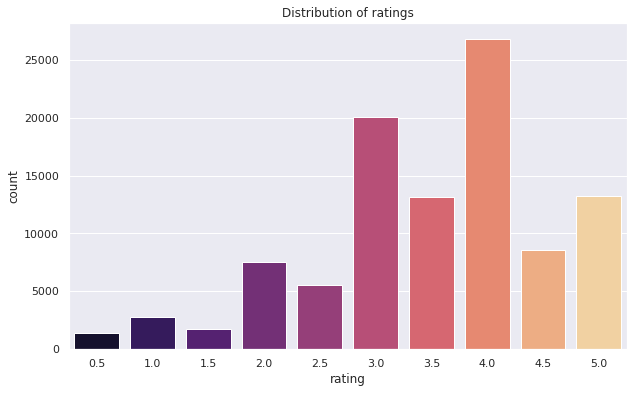

In [ ]:
sns.set(rc={'figure.figsize':(10,6)})
ax =sns.countplot(x='rating',data=ratings,palette="magma")
ax.set_title('Distribution of ratings');

In [ ]:
# the number of ratings each movie has recieved
ratings.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,movieId,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
224,260,251
418,480,238
97,110,237
507,589,224
461,527,220


In [ ]:
# the number of ratings each user has has done
ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print('Shape: ', movies.shape, '\n')
movies.info()

Shape:  (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


# Combining the Movies and Ratings DataFrame

Combine both the ratings and movies dataframe.

For that we need to merge on "movieId" attribute since it is common between both the dataframes.

In [ ]:
df_main = pd.merge(ratings, movies, on = 'movieId')

In [ ]:
df_main.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
df_main.shape

(100836, 5)

# Finding the distribution of genres



In [ ]:
genres = {} # create a dictionary to store different genre values

def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
            
find_genres()


In [ ]:
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [ ]:
# replace '(no genres listed)' by 'None'
genres['None'] = genres.pop('(no genres listed)')

In [ ]:
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 'None': 34}

# Plotting the genres using WordCloud

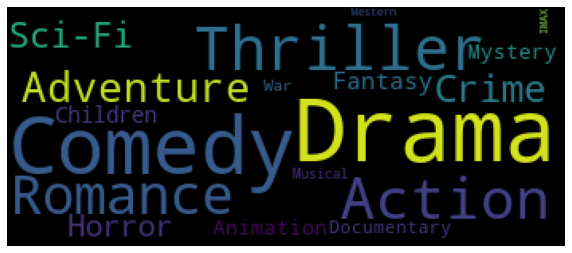

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=350, height=150, background_color = 'black', min_font_size=7).generate_from_frequencies(genres)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Finding heavily rated movies

In [ ]:
# Find movies with the most ratings
df_max_ratings = pd.DataFrame(df_main.groupby('title')['rating'].mean())
df_max_ratings['total ratings'] = pd.DataFrame(df_main.groupby('title')['rating'].count())
df_max_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)
df_max_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


# Plotting the total number of ratings

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


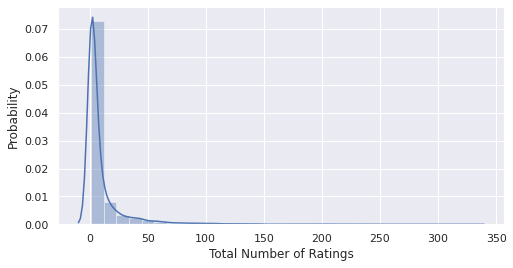

In [ ]:
sns.set_color_codes()
plt.figure(figsize=(8,4))
sns.distplot(df_max_ratings['total ratings'], bins=30)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

# Finding highly rated movies

In [ ]:
# Find movies with the highest ratings
df_max_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


In [ ]:
print('Total number of users that gave rating of 5.0 : ', len(df_max_ratings.loc[df_max_ratings['mean ratings'] == 5]), '\n')
print('Total number of Individual users that gave rating of 5.0 : ', len(df_max_ratings.loc[(df_max_ratings['mean ratings'] == 5) 
                                                                           & (df_max_ratings['total ratings'] == 1)]))

Total number of users that gave rating of 5.0 :  296 

Total number of Individual users that gave rating of 5.0 :  289


As you can see there are over 296 users that have rated 5 stars, among which there are 289 individual raters ( only user to rate the movie 5 star ).


So, this cannot be the lone factor that should be considered while recommending movies. As this factor only shows the preferences of a particular user.


It would make a good recommendation system if we can use both the factors ( -> Highly Rated Movies and Heavily Rated Movies <- ) together.

# Plotting the probability of ratings value 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


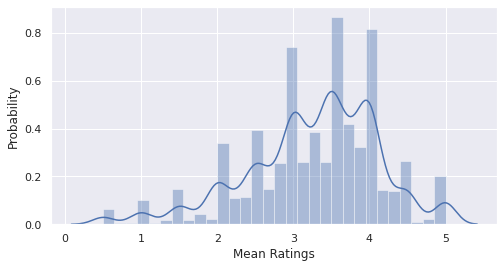

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(df_max_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

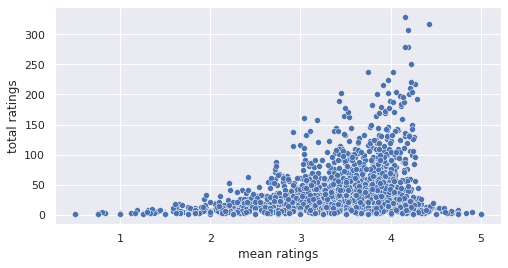

In [ ]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=df_max_ratings, x="mean ratings", y="total ratings")

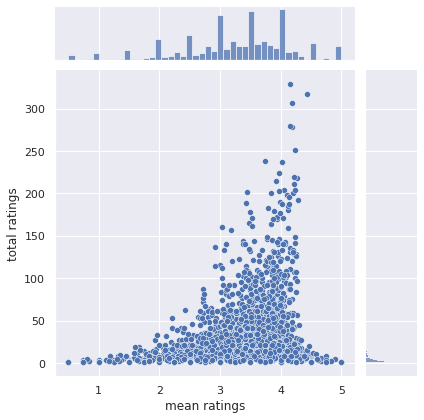

In [ ]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_max_ratings )

# Create User-Item Matrix

In [ ]:
df_main

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller


In [ ]:
user_item_matrix = df_main.pivot_table(index = 'userId', columns = 'title', values = 'rating')
user_item_matrix.head(20)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]Â² (2009),[REC]Â³ 3 GÃ©nesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),Â¡Three Amigos! (1986),Ã nous la libertÃ© (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


# Fill NaN values of user-item matrix

In [ ]:
final_user_item_matrix = user_item_matrix.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
final_user_item_matrix = final_user_item_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
final_user_item_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]Â² (2009),[REC]Â³ 3 GÃ©nesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),Â¡Three Amigos! (1986),Ã nous la libertÃ© (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.000000,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


# Find the correlation of user-item matrix

In [ ]:
final_user_item_matrix.T.corr()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.264516e-03,5.525772e-04,0.048419,0.021847,-0.045497,-6.199672e-03,0.047013,1.950985e-02,-8.754088e-03,...,0.018127,-0.017172,-0.015221,-3.705875e-02,-2.912138e-02,0.012016,0.055261,0.075224,-2.571255e-02,0.010932
2,0.001265,1.000000e+00,-4.975816e-17,-0.017164,0.021796,-0.021051,-1.111357e-02,-0.048085,7.652805e-16,3.011629e-03,...,-0.050551,-0.031581,-0.001688,-1.265569e-15,-6.430371e-16,0.006226,-0.020504,-0.006001,-6.009100e-02,0.024999
3,0.000553,-4.975816e-17,1.000000e+00,-0.011260,-0.031539,0.004800,-2.587070e-16,-0.032471,-4.812885e-16,3.774064e-16,...,-0.004904,-0.016117,0.017749,-8.106536e-16,-1.430628e-03,-0.037289,-0.007789,-0.013001,-1.168878e-16,0.019550
4,0.048419,-1.716402e-02,-1.125978e-02,1.000000,-0.029620,0.013956,5.809139e-02,0.002065,-5.873603e-03,5.159032e-02,...,-0.037687,0.063122,0.027640,-1.378212e-02,4.003747e-02,0.020590,0.014628,-0.037569,-1.788358e-02,-0.000995
5,0.021847,2.179571e-02,-3.153892e-02,-0.029620,1.000000,0.009111,1.011715e-02,-0.012284,7.750436e-16,-3.316512e-02,...,0.015964,0.012427,0.027076,1.246135e-02,-3.627206e-02,0.026319,0.031896,-0.001751,9.382892e-02,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,6.225827e-03,-3.728895e-02,0.020590,0.026319,-0.009137,2.832591e-02,0.022277,3.163273e-02,-3.994577e-02,...,0.053683,0.016384,0.098011,6.107833e-02,1.967830e-02,1.000000,0.017927,0.056676,3.842210e-02,0.075464
607,0.055261,-2.050374e-02,-7.789105e-03,0.014628,0.031896,0.045501,3.098070e-02,0.048822,-1.216061e-02,-1.765576e-02,...,0.049059,0.038197,0.049317,2.355180e-03,-2.938114e-02,0.017927,1.000000,0.044514,1.904919e-02,0.021860
608,0.075224,-6.000828e-03,-1.300064e-02,-0.037569,-0.001751,0.021727,2.841409e-02,0.071759,3.278284e-02,-5.199963e-02,...,0.069198,0.051388,0.012801,6.318649e-03,-7.977761e-03,0.056676,0.044514,1.000000,5.071449e-02,0.054454


In [ ]:
user_corr_matrix = final_user_item_matrix.T.corr()
corr_user_1 = user_corr_matrix.iloc[0]

In [ ]:
corr_user_1

userId
1      1.000000
2      0.001265
3      0.000553
4      0.048419
5      0.021847
         ...   
606    0.012016
607    0.055261
608    0.075224
609   -0.025713
610    0.010932
Name: 1, Length: 610, dtype: float64

# Item Based Collaborative Filtering

## Implementing user_based method with K nearest neighbors algorithm

In [ ]:
# After arranging the K neighbours based on mode, brute-force ended up picking the first class instead of 
# picking the class which had least distance in the distance metric
from sklearn.neighbors import NearestNeighbors
model_knn=NearestNeighbors(metric="cosine",algorithm="brute")
model_knn.fit(final_user_item_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
query_index=50

distances,indices=model_knn.kneighbors(final_user_item_matrix.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)
print("Distances -->",distances," Indices -->",indices)
 
print(distances.flatten())
print(len(distances.flatten()))
 
for i in range(0,len(distances.flatten())):
    if i==0:
        print("Recommendation for {0}:\n".format(final_user_item_matrix.index[query_index]))
    else:
        print("{0}: {1}, with distance of {2}:".format(i,final_user_item_matrix.index[indices.flatten()[i]],distances.flatten()[i]))

Distances --> [[0.         0.00198493 0.00199    0.00199066 0.00199206 0.00199695]]  Indices --> [[ 50  52  48 514  24 122]]
[0.         0.00198493 0.00199    0.00199066 0.00199206 0.00199695]
6
Recommendation for 51:

1: 53, with distance of 0.0019849338299237074:
2: 49, with distance of 0.0019900000836668985:
3: 515, with distance of 0.0019906593433323128:
4: 25, with distance of 0.0019920620161969493:
5: 123, with distance of 0.001996948357219419:


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


## Find the correlation of the first user with all other users

In [ ]:
corr_user_1.sort_values(ascending=False, inplace=True)

In [ ]:
corr_user_1

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
         ...   
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
53          NaN
Name: 1, Length: 610, dtype: float64

In [ ]:
# NaN values are generated in corr() as the std dev is zero, which is required in calculating Pearson Similarity.
corr_user_1.dropna(inplace = True)

In [ ]:
corr_user_1

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
         ...   
395   -0.075800
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
Name: 1, Length: 609, dtype: float64

In [ ]:
# Neglect the 1st corr value as it is user1 itself
top50_corr_users = corr_user_1[1:51]

In [ ]:
top50_corr_users.keys()

Int64Index([301, 597, 414, 477,  57, 369, 206, 535, 590, 418, 120,  75, 577,
            198, 160, 226, 266, 312,  19, 135, 484, 469,  72, 593,  44, 297,
            434, 483, 449, 552, 171, 199,  45, 608, 494, 116, 450, 201, 387,
            173, 600, 513, 524, 368, 555, 180, 445,  20, 307, 480],
           dtype='int64', name='userId')

## Find the list of all movies that have been rated by user 1

In [ ]:
df_main[ df_main['userId'] == 1]

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
215,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
267,1,6,4.0,Heat (1995),Action|Crime|Thriller
369,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
572,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
16056,1,3744,4.0,Shaft (2000),Action|Crime|Thriller
16075,1,3793,5.0,X-Men (2000),Action|Adventure|Sci-Fi
16208,1,3809,4.0,What About Bob? (1991),Comedy
16243,1,4006,4.0,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [ ]:
# user1 has not rated 32 movie
df_main[ (df_main['userId'] == 1) & (df_main['movieId'] == 32) ] 

,userId,movieId,rating,title,genres


In [ ]:
print('32nd Movie : ', movies['title'][ movies['movieId'] == 32 ].values)

32nd Movie :  ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


So, let's calculate what ratings user 1 would give to the movie with the help of similarrity vector. And based on that rating, we can compare it with a threshold rating. If the rating is higher it will be visible to the active user in his/her recommended list.

In [ ]:
df_max_ratings.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean ratings,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


In [ ]:
# Now we check if each user in top50 list has rated the movie 32
top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
    if df_main[ (df_main['userId'] == user) & (df_main['movieId'] == 32) ]['rating'].sum()  :
        count +=1
        users.append(user)

print(count)

30


There are 30 similar users among the Top-50 similar users that have rated the movie "The Twelve Monkeys".

Now, let's calculate the rating user 1 would give to the movie,

Predicted rating = sum of [ (weights) * (ratings) ] / sum of (weights)

Here, weights is the correlation of the corresponding user with the first user.

In [ ]:
# Let's define a function to calculate what user1 will rate the movie
# We use Weighted average of k similar users
# ratings here is the number that user has given to movie 32
def predict_rating():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top50_corr_users.loc[user] * df_main[ (df_main['userId'] == user) & (df_main['movieId'] == 32) ]['rating'].sum()
        sum_similarity += top50_corr_users.loc[user]
    #print(weighted_ratings)
    #print(sum_similarity)
    print(weighted_ratings / sum_similarity)
    
    
predict_rating()

4.1368953015974315


In [ ]:
df_m[ df_m['movieId'] == 32]

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


Well there are pretty good of recommending this movie to the 1st user, since the rating is quite good.



# Item Based Collaborative Filtering

It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike.
Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset.

In [ ]:
# Let's find similar movies to jurassic Park
df_max_ratings.loc[['Jurassic Park (1993)']]

,mean ratings,total ratings
title,,
Jurassic Park (1993),3.75,238


In [ ]:
item_util_matrix = user_item_matrix.copy()
item_util_matrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]Â² (2009),[REC]Â³ 3 GÃ©nesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),Â¡Three Amigos! (1986),Ã nous la libertÃ© (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


## Fill NaN values of user-item matrix

In [ ]:
# We will fill the column wise NaN's with the corresponding movie's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated movie.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]Â² (2009),[REC]Â³ 3 GÃ©nesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),Â¡Three Amigos! (1986),Ã nous la libertÃ© (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0


In [ ]:
item_util_matrix.isna().sum().sum()

0

In [ ]:
item_util_matrix.corr()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]Â² (2009),[REC]Â³ 3 GÃ©nesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),Â¡Three Amigos! (1986),Ã nous la libertÃ© (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,1.000000e+00,NaN,-2.470228e-17,NaN,-6.783236e-16,-4.090781e-16,...,NaN,1.491400e-15,-2.970631e-18,NaN,NaN,-1.174172e-16,-4.643126e-16,-1.457468e-15,2.901144e-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,-1.174172e-16,NaN,6.069910e-02,NaN,-7.527708e-02,2.947366e-02,...,NaN,-1.447002e-15,-3.196632e-16,NaN,NaN,1.000000e+00,3.784587e-02,1.243849e-15,-3.410933e-02,NaN
xXx (2002),NaN,NaN,NaN,NaN,-4.643126e-16,NaN,-3.527098e-03,NaN,1.558884e-01,2.511177e-01,...,NaN,-2.067568e-01,-4.854206e-03,NaN,NaN,3.784587e-02,1.000000e+00,2.449296e-01,1.854832e-02,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,-1.457468e-15,NaN,6.027298e-16,NaN,1.107823e-01,-1.311693e-15,...,NaN,-2.014024e-01,7.715167e-02,NaN,NaN,1.243849e-15,2.449296e-01,1.000000e+00,1.034849e-15,NaN


In [ ]:
item_corr_matrix = item_util_matrix.corr()

In [ ]:
jurassic_park_corr = item_corr_matrix['Jurassic Park (1993)']
jurassic_park_corr = jurassic_park_corr.sort_values(ascending=False)
jurassic_park_corr.dropna(inplace=True)

In [ ]:
movies_similar_to_jurassic_park = pd.DataFrame(data=jurassic_park_corr.values, columns=['Correlation'], 
                                               index = jurassic_park_corr.index)
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park.join(df_max_ratings['total ratings'])
movies_similar_to_jurassic_park.head(10)

,Correlation,total ratings
title,,
Jurassic Park (1993),1.000000,238
"Fugitive, The (1993)",0.324717,190
Lethal Weapon (1987),0.318646,75
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Mulan (1998),0.255672,45
Rise of the Planet of the Apes (2011),0.248134,27
"Bug's Life, A (1998)",0.240964,92


In [ ]:
# we don't need the first row which is Jurassic Park itself
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park[1:]
movies_similar_to_jurassic_park[ movies_similar_to_jurassic_park['total ratings'] > 100 ].sort_values(ascending=False,
                                                                                          by=['Correlation']).head(10)

,Correlation,total ratings
title,,
"Fugitive, The (1993)",0.324717,190
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Indiana Jones and the Temple of Doom (1984),0.239826,108
Die Hard (1988),0.239294,145
Aladdin (1992),0.227711,183
Braveheart (1995),0.222085,237
Speed (1994),0.220720,171


# Model Based Collaborative Filtering
Here we will be using dimensionality reduction methods to improve robustness and accuracy of Memory-Based CF. Basically, we compress user-item matrix into a low dimension matrix. We use techniques like SVD which is a low-rank factorization method, PCA which is used for dimensionaliry reduction etc.

Model-based methods are based on matrix factorization and are better at dealing with sparsity.

In next steps we are going to implement for both model and memory based using surprise library.




# Dimension Reduction

We are going to filter out rarely rated movies and rarely rating users.

In [ ]:
# we assume that min number of rated movies should be 5
min_movie_ratings = 5
reduced_dim_movies = ratings['movieId'].value_counts() > min_movie_ratings
reduced_dim_movies = reduced_dim_movies[reduced_dim_movies].index.tolist()

# we assume that each user had to rated at least 5 movies
min_user_ratings = 5
reduced_dim_users = ratings['userId'].value_counts() > min_user_ratings
reduced_dim_users = reduced_dim_users[reduced_dim_users].index.tolist()

reduced_dim_df = ratings[(ratings['movieId'].isin(reduced_dim_movies)) & (ratings['userId'].isin(reduced_dim_users))]
print('The original dataframe shape:\t{}'.format(ratings.shape))
print('The new dataframe shape:\t{}'.format(reduced_dim_df.shape))

The original dataframe shape:	(100836, 3)
The new dataframe shape:	(88364, 3)


# Surprise

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reduced_dim_df[['userId', 'movieId', 'rating']], reader)

In [ ]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    results = cross_validate(algorithm, data, measures=['RMSE','MAE','MSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    res = pd.DataFrame.from_dict(results).mean(axis=0)
    res = res.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(res)
    print("Finished Successfuly: " ,str(algorithm), "\n\n")

print ('\n\tAll Algorithms were done succesfuly\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f63ccf36210>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f63ccf36a90>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7f63ccf36a10>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f63cce91910>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f63ccf84b90>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7f63ccf84b50>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f63ccf08c50>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f63ccf08d10>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7f63ccf08890>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7f63ccf08c10>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7f63ccf08510>] 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f63ccf3

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse').round(4)

In [ ]:
surprise_results

,test_rmse,test_mae,test_mse,fit_time,test_time
Algorithm,,,,,
SVDpp,0.8419,0.6444,0.7088,316.5185,6.6474
KNNBaseline,0.8478,0.6483,0.7188,0.3566,1.6641
SVD,0.8560,0.6564,0.7327,4.5083,0.1773
BaselineOnly,0.8563,0.6587,0.7333,0.2670,0.1081
KNNWithZScore,0.8605,0.6543,0.7405,0.2171,1.5254
KNNWithMeans,0.8615,0.6594,0.7422,0.1571,1.5213
SlopeOne,0.8633,0.6609,0.7453,1.7144,4.2979
NMF,0.8859,0.6796,0.7849,4.3768,0.1493
CoClustering,0.9091,0.7081,0.8265,1.8343,0.1133


# Plotting

## Comparison of fit time and test time for all algorithms

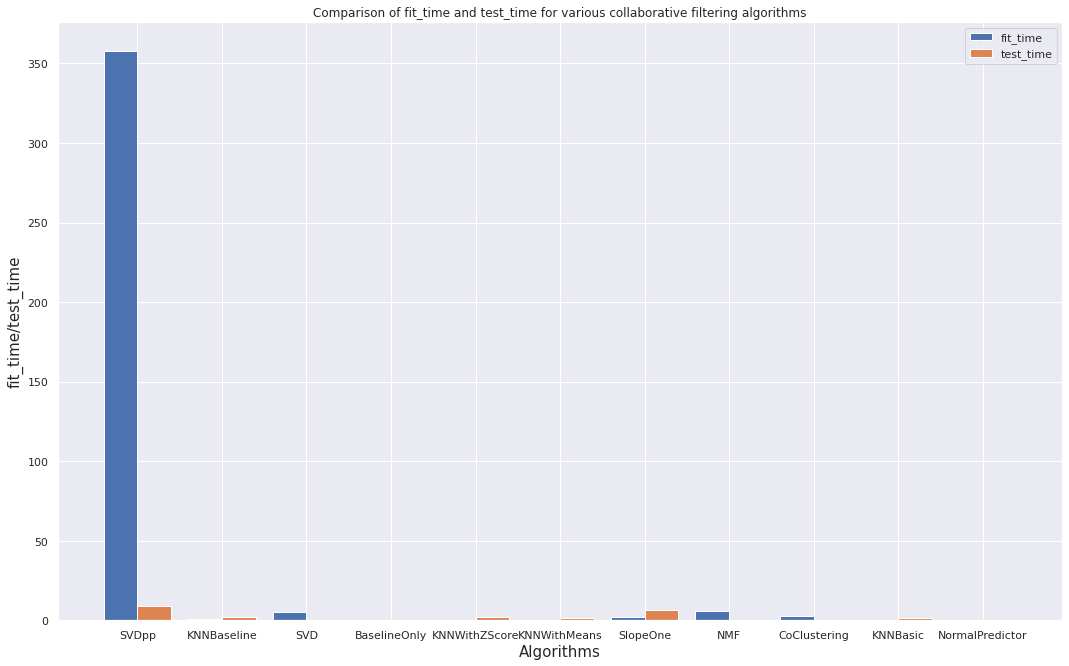

In [ ]:

X = ['SVDpp', 'KNNBaseline', 'SVD', 'BaselineOnly','KNNWithZScore','KNNWithMeans','SlopeOne','NMF','CoClustering','KNNBasic','NormalPredictor']
fit_time = [357.91, 0.65,4.95,0.46,0.29,0.24 ,2.38,6.06,2.60,0.20,0.16	]
test_time = [9.26,2.14,0.21,0.13,1.94,1.71,6.31, 0.15,0.18,1.69,0.19]
plt.figure(figsize=[18, 11])
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, fit_time, 0.4, label = 'fit_time')
plt.bar(X_axis + 0.2, test_time, 0.4, label = 'test_time')


plt.xticks(X_axis, X)
plt.xlabel("Algorithms",fontsize=15)
plt.ylabel("fit_time/test_time",fontsize=15)
plt.title("Comparison of fit_time and test_time for various collaborative filtering algorithms")
plt.legend()
plt.show()


## Comparison of fit time and test time for all algorithms except SVDpp

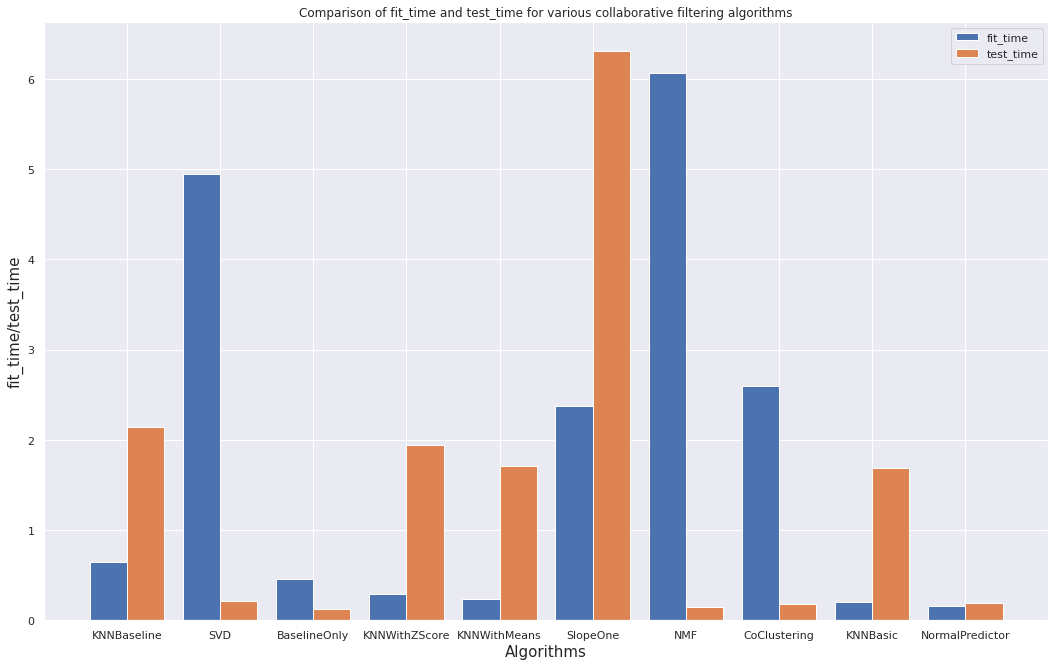

In [ ]:
X = [ 'KNNBaseline', 'SVD', 'BaselineOnly','KNNWithZScore','KNNWithMeans','SlopeOne','NMF','CoClustering','KNNBasic','NormalPredictor']
# fit_time = [0.655033,4.953458,0.465787,0.292804,0.243279 ,2.380236,6.066900,2.606733,0.203657,0.163997	]
# test_time = [2.149705,0.211622,0.131523,1.941219,1.711747,6.310500, 0.155767,0.185032,1.697633,0.195223]
fit_time = [0.65,4.95,0.46,0.29,0.24 ,2.38,6.06,2.60,0.20,0.16	]
test_time = [2.14,0.21,0.13,1.94,1.71,6.31, 0.15,0.18,1.69,0.19]
plt.figure(figsize=[18, 11])
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, fit_time, 0.4, label = 'fit_time')
plt.bar(X_axis + 0.2, test_time, 0.4, label = 'test_time')


plt.xticks(X_axis, X)
plt.xlabel("Algorithms",fontsize=15)
plt.ylabel("fit_time/test_time",fontsize=15)
plt.title("Comparison of fit_time and test_time for various collaborative filtering algorithms")
plt.legend()
plt.show()


## Comparison of RMSE and MAE for all algorithms

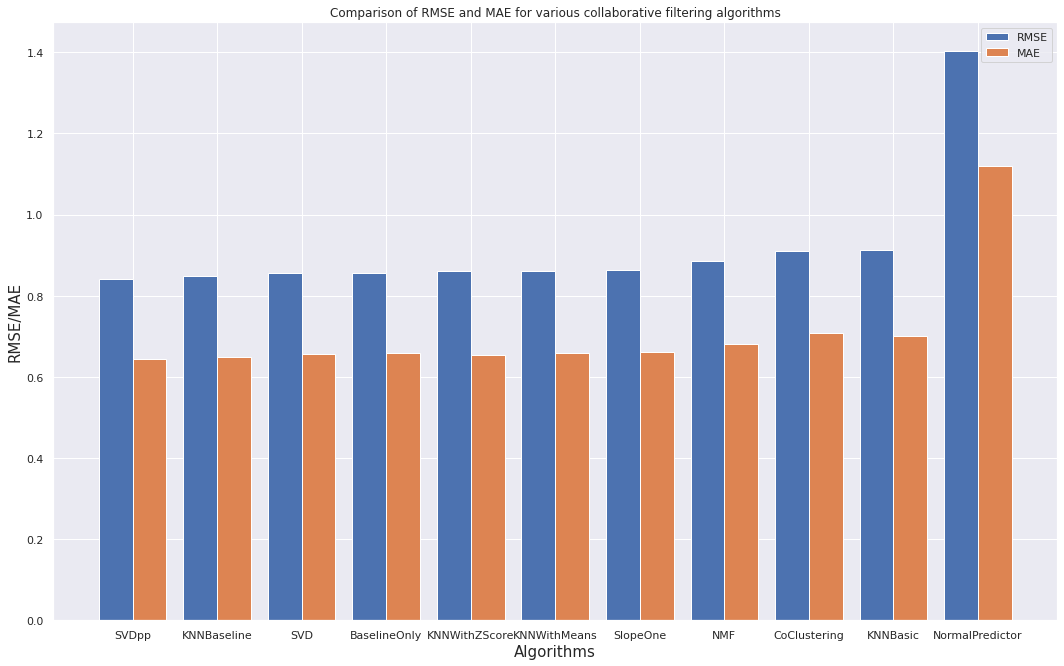

In [ ]:
X = ['SVDpp', 'KNNBaseline', 'SVD', 'BaselineOnly','KNNWithZScore','KNNWithMeans','SlopeOne','NMF','CoClustering','KNNBasic','NormalPredictor']
rmse = [0.841514,0.847613,0.855466	,0.855960,0.860352,0.861345,0.863328,0.885533,0.910285,0.912921,1.403610	]
mae = [0.643685,0.647978	,0.656337,0.658541,0.654591	,0.659413,0.660837,0.679917,0.709323,0.701748,1.120253]
plt.figure(figsize=[18, 11])
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, rmse, 0.4, label = 'RMSE')
plt.bar(X_axis + 0.2, mae, 0.4, label = 'MAE')


plt.xticks(X_axis, X)
plt.xlabel("Algorithms",fontsize=15)
plt.ylabel("RMSE/MAE",fontsize=15)
plt.title("Comparison of RMSE and MAE for various collaborative filtering algorithms")
plt.legend()
plt.show()


## Mean of RMSE for all algorithms

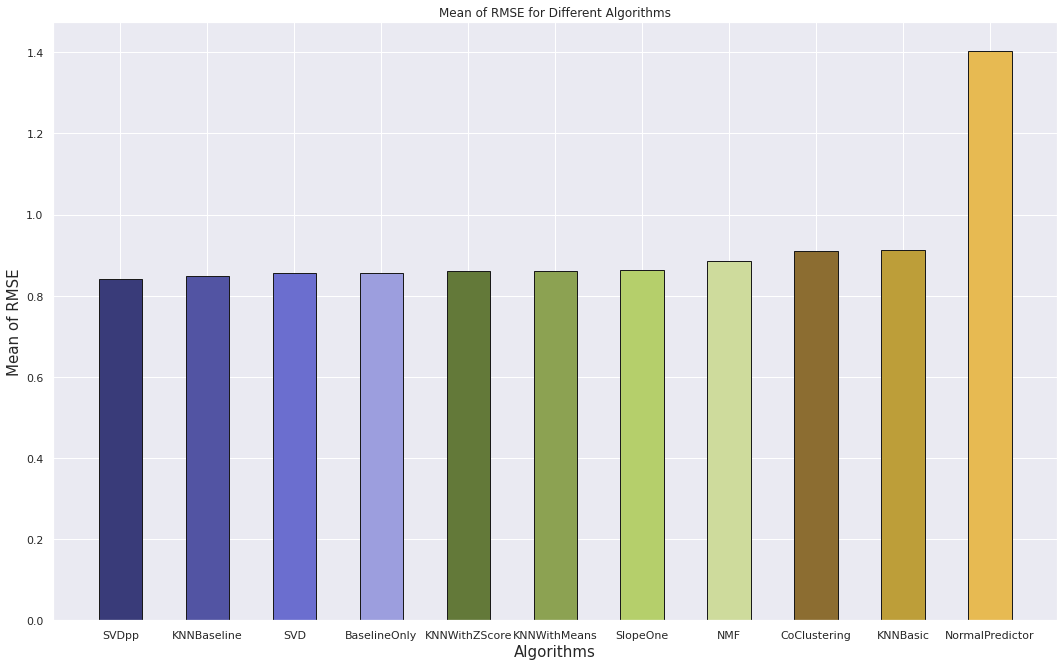

In [ ]:
# Preparing the data to plot
algs = ['SVDpp', 'KNNBaseline', 'SVD', 'BaselineOnly','KNNWithZScore','KNNWithMeans','SlopeOne','NMF','CoClustering','KNNBasic','NormalPredictor']
meanOfrmse = [0.8415,0.8476,0.8554	,0.8559,0.8603,0.8613,0.8633,0.8855,0.9102,0.9129,1.4036	]

plt.figure(figsize=[18, 11])
col_map = plt.get_cmap('tab20b')
# Creating a simple bar chart
plt.bar(algs, meanOfrmse, width=0.5,color=col_map.colors, edgecolor='k')

plt.title('Mean of RMSE for Different Algorithms')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Mean of RMSE', fontsize=15)
plt.show()

# References
* The above code adopted from this link, and used in this implementation by making some changes. All figures' codes and results are written from scratch.

https://www.the-odd-dataguy.com/2022/03/14/surprise/

https://github.com/Chinmayrane16/Recommender-Systems-with-Collaborative-Filtering-and-Deep-Learning-Techniques/blob/master/Recommendation%20Systems%20with%20CF%20and%20DL%20Techniques.ipynb

